In [ ]:
import ccdproc
import os
import datetime
import matplotlib.pyplot as plt
import numpy as np

from astropy import units as u
from astropy.coordinates import SkyCoord, ICRS

from multiprocessing import Lock

OBSV_DATE = datetime.date(year=2022, month=12, day=6).strftime("%Y-%m-%d")
# OBJ_DATA_DIR = "/run/media/ramon/USBD/Tesis/IturbideDatos/ATOJ339.9469+45.1464/"
OBJ_DATA_DIR = "/run/media/ramon/ROG_Data/Tesis/IturbideDatos/ATOJ339.9469+45.1464"

DATE_DATA_DIR = [os.path.join(OBJ_DATA_DIR, d) for d in os.listdir(OBJ_DATA_DIR) if OBSV_DATE in d and os.path.isdir(os.path.join(OBJ_DATA_DIR, d))][0]
DATA_DIR = os.path.join(DATE_DATA_DIR, "corrected", "iraf-shifted")
CCD_KWARGS = {'unit': 'adu'}

OBJ_COORD = SkyCoord(339.94692562872, 45.14639621713, unit=u.deg, frame=ICRS)

# Coordinates obtained from SIMBAD Gaia DR3 measurements
REF_OBJS_COORDS = {
	# Not currently used; outside of frame
	# "HD 214804": SkyCoord(340.00377780131, 45.24015031351, unit=u.deg, frame=ICRS), # http://simbad.cds.unistra.fr/simbad/sim-id?Ident=%404410&Name=HD%20214804
	
	"TYC 3620-332-1": SkyCoord(339.88604238078, 45.12830357108, unit=u.deg, frame=ICRS), # http://simbad.cds.unistra.fr/simbad/sim-id?Ident=%406898038&Name=TYC%203620-332-1
	"TYC 3620-254-1": SkyCoord(339.99378670432, 45.10213449513, unit=u.deg, frame=ICRS) # http://simbad.cds.unistra.fr/simbad/sim-id?Ident=%406898031&Name=TYC%203620-254-1
}

def getMkdir(dirPath: str) -> str:
	if not os.path.exists(dirPath):
		os.mkdir(dirPath)
	return dirPath

LOGGING_LOCK = Lock()
def printToLog(msg: str):
	with LOGGING_LOCK:
		with open(os.path.join(OBJ_DATA_DIR, f"{OBSV_DATE}.log"), "a+") as logFile:
			logFile.write(f"[{datetime.datetime.now()}] {msg}\n")

assert os.path.exists(DATA_DIR), DATA_DIR
DATA_DIR

In [ ]:
import math

from lmfit.model import ModelResult

def percentile(fitResult: ModelResult, percentile: float) -> float:
	"""
	Assumes percentile is given as its percent value (ie. 1 <= percentile <= 99)
	"""
	assert percentile >= 1 and percentile <= 99
	return fitResult.params['sigma'] * math.sqrt(2 * math.log(100.0 / (100 - percentile)))

def plotRadialModel(fitResult: ModelResult, radialProfile: np.ndarray, radialXCoords: np.ndarray, objCenterX: int):
	modelCenter = fitResult.params['center'].value + min(radialXCoords)

	plt.scatter(radialXCoords, radialProfile)
	plt.plot(radialXCoords, fitResult.best_fit, '--', color='green')
	plt.axvline(objCenterX, color='red')
	plt.axvline(modelCenter, color='orange', marker="2")

	plt.axvline(modelCenter - (fitResult.params['fwhm']/2), color='cyan', marker='2')
	plt.axvline(modelCenter + (fitResult.params['fwhm']/2), color='cyan', marker='2')

	percentile80 = percentile(fitResult, 80)
	plt.axvline(modelCenter - (percentile80), color='purple')
	plt.axvline(modelCenter + (percentile80), color='purple')

	percentile90 = percentile(fitResult, 90)
	plt.axvline(modelCenter - (percentile90), color='blue')
	plt.axvline(modelCenter + (percentile90), color='blue')

	percentile95 = percentile(fitResult, 99)
	plt.axvline(modelCenter - (percentile95), color='pink')
	plt.axvline(modelCenter + (percentile95), color='pink')
	
	plt.show()

s_bdf_2022-12-06_19-31-37_0000.fits
--------------------
Parameters([('amplitude', <Parameter 'amplitude', value=3144.0217531904923 +/- 217, bounds=[-inf:inf]>), ('center', <Parameter 'center', value=40.00688331362264 +/- 0.319, bounds=[-inf:inf]>), ('sigma', <Parameter 'sigma', value=4.872576139845854 +/- 0.343, bounds=[0:inf]>), ('c', <Parameter 'c', value=28.191302817931092 +/- 4.76, bounds=[-inf:inf]>), ('fwhm', <Parameter 'fwhm', value=11.474039745631814 +/- 0.809, bounds=[-inf:inf], expr='2.3548200*sigma'>), ('height', <Parameter 'height', value=257.41686398922593 +/- 15, bounds=[-inf:inf], expr='0.3989423*amplitude/max(1e-15, sigma)'>)])


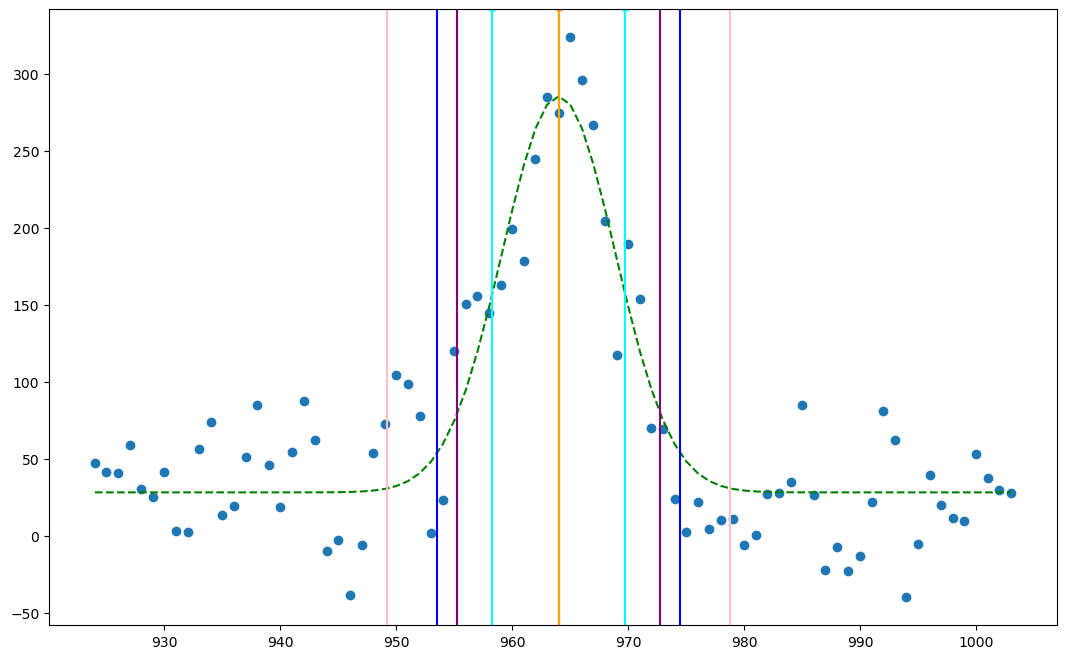

Model center:  (964.0068833136227, 599.9750119988993)
--------------------
FWHM:  11.474039745631814
p80W:  17.483997730985582
p90W:  20.912765713234585
p99W:  29.575116898387407
TYC 3620-332-1: (755.3728416913707, 1413.2395034219674)
TYC 3620-254-1: (1072.6222305352871, 657.4051833572232)


KeyboardInterrupt: Interrupted by user

In [4]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (13,8)

from lmfit.models import GaussianModel, ConstantModel
from IPython.display import clear_output
from astropy.visualization import SqrtStretch, ImageNormalize, ZScaleInterval

from astropy import log
log.setLevel('ERROR')

obsvImages = ccdproc.ImageFileCollection(DATA_DIR)
mod = GaussianModel() + ConstantModel()
for img, img_fname in obsvImages.ccds(ccd_kwargs=CCD_KWARGS, return_fname=True):
	print(img_fname)

	objPxCoord = OBJ_COORD.to_pixel(img.wcs)
	objCenterX, objCenterY = round(objPxCoord[0].item()), round(objPxCoord[1].item())

	# Had to flip X and Y coords due to FITS data shape
	RADIUS = 40
	radialXCoords = np.arange(objCenterX-RADIUS, objCenterX+RADIUS)
	radialProfile = img.data[objCenterY, radialXCoords]
	radialProfile -= min(radialProfile) + 40 # subtracted constant to make lmfit happy

	# Remove bad pixels, just in case
	imgMask = ~np.isnan(radialProfile)
	correctedRadialProf = radialProfile[imgMask]
	correctedXCoords = radialXCoords[imgMask]

	normalizedX = radialXCoords - min(radialXCoords)
	fitResult: ModelResult = mod.fit(correctedRadialProf, x=normalizedX)
	print('--------------------')
	print(fitResult.params)
	plotRadialModel(fitResult, radialProfile, radialXCoords, objCenterX)
	
	print("Model center: ", (min(radialXCoords) + fitResult.params['center'], objPxCoord[1].item()))
	print('--------------------')
	print("FWHM: ", fitResult.params['fwhm'].value)
	print("p80W: ", 2 * percentile(fitResult, 80))
	print("p90W: ", 2 * percentile(fitResult, 90))
	print("p99W: ", 2 * percentile(fitResult, 99))
	
	norm = ImageNormalize(img, interval=ZScaleInterval(), stretch=SqrtStretch())
	# plt.imshow(img.data, cmap='gray', origin='lower', norm=norm)
	# plt.colorbar()
	# plt.scatter(objCenterX, objCenterY, marker='.', alpha=0.6)
	for refSkyName, refSkyCoord in REF_OBJS_COORDS.items():
		refPxCoord = refSkyCoord.to_pixel(img.wcs)
		refCenterX, refCenterY = refPxCoord[0].item(), refPxCoord[1].item()
		print(f"{refSkyName}: ({refCenterY}, {refCenterX})") # had to flip due to fits data array format
		# plt.scatter(refCenterX, refCenterY, marker='.', alpha=0.6, color='orange')
	plt.show()

	input()
	clear_output()
	plt.clf()

In [ ]:
# Trying to extract magnitudes and flux a different way. NOT WORKING SO FAR

import numpy as np
import pandas as pd
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from photutils.aperture import CircularAperture

from astropy import log
log.setLevel('ERROR')

allPos = []
objPos = []
dataImages = ccdproc.ImageFileCollection(DATA_DIR)
for img, img_fname in dataImages.ccds(ccd_kwargs=CCD_KWARGS, return_fname=True):
	objPos.append(findStar(img, [OBJ_COORD.to_pixel(img.wcs)])[0])
	
	wcsRefPos = [p.to_pixel(img.wcs) for p in REF_OBJS_COORDS.values()]
	refPos = findStar(img, filter(lambda p: validStarPos(img, p), wcsRefPos))
	# for refName, refCoord in REF_OBJS_COORDS.items():
	# 	pixelCoord = refCoord.to_pixel(img.wcs)
	# 	if validStarPos(img, pixelCoord):
	# 		print(f"Using {refName} as a reference star")
	# 		refPos.append(findStar(img, pixelCoord))
	allPos.append(refPos)
	break

print(allPos)
print('---------------------')
print(objPos)
# shiftedImages = ccdproc.ImageFileCollection(DATA_DIR)
# for img, img_fname in shiftedImages.ccds(ccd_kwargs=CCD_KWARGS, return_fname=True):
# 	data = img.data
# 	mean, median, std = sigma_clipped_stats(data)
# 	daofind = DAOStarFinder(fwhm=7.0, threshold=5.*std)

# 	sources = daofind(data)
# 	pandasSources = sources.to_pandas()
# 	pandasSources['xdist'] = abs(pandasSources['xcentroid'] - 964)
# 	pandasSources['ydist'] = abs(pandasSources['ycentroid'] - 599)
# 	iturbideObj = pandasSources.sort_values(by=['xdist', 'ydist']).head(1)
# 	print(iturbideObj)

# 	positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
# 	apertures = CircularAperture(positions, r=4.0)

# 	objPos = np.transpose((iturbideObj['xcentroid'], iturbideObj['ycentroid']))
# 	objAperture = CircularAperture(objPos, r=4.0)

# 	norm = ImageNormalize(stretch=SqrtStretch())
# 	plt.imshow(data, cmap='Greys', origin='lower', norm=norm, interpolation='nearest')
# 	apertures.plot(color='blue', lw=1.5, alpha=0.5)
# 	objAperture.plot(color='red', lw=1.5, alpha=0.5)
# 	break

In [ ]:
# Aperture photometry

from photutils.aperture import SkyCircularAperture, aperture_photometry
from astropy.wcs import WCS

DATE_OBSV_FIELD = "DATE-OBS"

obsvImages = ccdproc.ImageFileCollection(DATA_DIR)

aperture = SkyCircularAperture(OBJ_COORD, r=0.28 * u.arcsec)
starFlux: None
for img, img_fname in obsvImages.ccds(ccd_kwargs=CCD_KWARGS, return_fname=True):
	starFlux = aperture_photometry(img, aperture)
	dateObsv = img.header[DATE_OBSV_FIELD]
	break
starFlux